In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from collections import Counter

In [2]:
from transformers import BertForSequenceClassification

mbert_model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=4)
mbert_model.load_state_dict(torch.load("mbert_model.pth", map_location=torch.device('cpu')))

mbert_model.eval()

print("mBERT model loaded successfully!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_10864\106451061.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

mBERT model loaded successfully!


In [3]:
banglabert_model = BertForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=4)
banglabert_model.load_state_dict(torch.load("banglabert_model.pth", map_location=torch.device('cpu')))

banglabert_model.eval()

print("banglaBERT model loaded successfully!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_10864\4139795196.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `

banglaBERT model loaded successfully!


In [4]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=4)
xlmr_model.load_state_dict(torch.load("xlmr_model.pth", map_location=torch.device('cpu')))

xlmr_model.eval()

print("xlmr model loaded successfully!")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_10864\1184878337.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via th

xlmr model loaded successfully!


In [5]:
from transformers import BertTokenizer

# Load the same tokenizer used during training
mbert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")
banglabert_tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')



print("Tokenizer loaded successfully!")


Tokenizer loaded successfully!


In [6]:
class CyberbullyingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [7]:
mbert_test_dataset = torch.load("mbert_test_dataset.pth")
banglabert_test_dataset = torch.load("banglabert_test_dataset.pth")
xlmr_test_dataset = torch.load("xlmr_test_dataset.pth")

test_labels = torch.load("bangla_test_labels.pth")

C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_10864\1002518900.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mbert_test_dataset = torch.load("mbert_test_dataset.pth")

In [8]:

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm


In [9]:
def evaluate_model(model, test_dataset, batch_size=16):
    model.eval()  # Set model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move inputs to device (CPU/GPU)
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)
            
            outputs = model(**inputs)
            logits = outputs.logits  # Get raw scores
            preds = torch.argmax(logits, dim=1)  # Get class with highest probability
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


In [10]:
# # Example input text
# text = "i hate you!"

# # Tokenize the input
# inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# # Perform inference
# with torch.no_grad():
#     outputs = roberta_model(**inputs)

# # Get predicted class
# predicted_class = torch.argmax(outputs.logits, dim=1).item()
# print(f"Predicted Class: {predicted_class}")


In [11]:
mbert_accuracy = evaluate_model(mbert_model, mbert_test_dataset)
banglabert_accuracy = evaluate_model(banglabert_model, banglabert_test_dataset)
xlmr_accuracy = evaluate_model(xlmr_model, xlmr_test_dataset)

print(f"mBERT Model Accuracy: {mbert_accuracy:.4f}")
print(f"BanglaBERT Model Accuracy: {banglabert_accuracy:.4f}")
print(f"XLM-R Model Accuracy: {xlmr_accuracy:.4f}")

Evaluating:   0%|                                                                              | 0/305 [00:00<?, ?it/s]C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_10864\2646260844.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating:   0%|                                                                              | 0/305 [00:00<?, ?it/s]C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_10864\2646260844.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating:   0%|                                                       

mBERT Model Accuracy: 0.8587
BanglaBERT Model Accuracy: 0.8597
XLM-R Model Accuracy: 0.8474


In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

GPU is available and being used: NVIDIA GeForce RTX 3070


In [13]:
from torch.utils.data import DataLoader
from collections import Counter
import torch.nn.functional as F
import torch

# Define the ensemble prediction function
def ensemble_predict(mbert_model, banglabert_model, xlmr_model, mbert_dataset, banglabert_dataset, xlmr_dataset, batch_size=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mbert_model.to(device)
    banglabert_model.to(device)
    xlmr_model.to(device)

    mbert_loader = DataLoader(mbert_dataset, batch_size=batch_size, shuffle=False)
    banglabert_loader = DataLoader(banglabert_dataset, batch_size=batch_size, shuffle=False)
    xlmr_loader = DataLoader(xlmr_dataset, batch_size=batch_size, shuffle=False)

    all_preds_hard = []
    all_preds_soft = []

    for (mbert_batch, banglabert_batch, xlmr_batch) in zip(mbert_loader, banglabert_loader, xlmr_loader):
        mbert_inputs = {key: val.to(device) for key, val in mbert_batch.items() if key != "labels"}
        banglabert_inputs = {key: val.to(device) for key, val in banglabert_batch.items() if key != "labels"}
        xlmr_inputs = {key: val.to(device) for key, val in xlmr_batch.items() if key != "labels"}

        with torch.no_grad():
            mbert_outputs = mbert_model(**mbert_inputs).logits
            banglabert_outputs = banglabert_model(**banglabert_inputs).logits
            xlmr_outputs = xlmr_model(**xlmr_inputs).logits
            
            mbert_probs = F.softmax(mbert_outputs, dim=1)
            banglabert_probs = F.softmax(banglabert_outputs, dim=1)
            xlmr_probs = F.softmax(xlmr_outputs, dim=1)
            
            avg_probs = (mbert_probs + banglabert_probs + xlmr_probs) / 3
            final_preds_soft = torch.argmax(avg_probs, dim=1).cpu().numpy()
            
            mbert_preds = torch.argmax(mbert_probs, dim=1).cpu().numpy()
            banglabert_preds = torch.argmax(banglabert_probs, dim=1).cpu().numpy()
            xlmr_preds = torch.argmax(xlmr_probs, dim=1).cpu().numpy()
            
            final_preds_hard = [Counter([m, b, x]).most_common(1)[0][0] for m, b, x in zip(mbert_preds, banglabert_preds, xlmr_preds)]

            all_preds_soft.extend(final_preds_soft)
            all_preds_hard.extend(final_preds_hard)

    return all_preds_hard, all_preds_soft


In [14]:
# # Run ensemble prediction
# hard_preds, soft_preds = ensemble_predict(bert_model, roberta_model, bert_test_dataset, roberta_test_dataset, albert_model, albert_test_dataset, gpt2_model, gpt2_test_dataset, xlnet_model, xlnet_test_dataset)

In [15]:
# # Print first 10 predictions from both methods
# print("Majority Voting Predictions:", hard_preds[:10])
# print("Softmax Averaging Predictions:", soft_preds[:10])

In [ ]:
# from sklearn.metrics import accuracy_score

# # Load the actual test labels
# test_labels = torch.load("bangla_test_labels.pth")  # Ensure this file contains the correct test labels

# # Run the ensemble prediction function
# # hard_preds, soft_preds = ensemble_predict(mbert_model, banglabert_model, mbert_test_dataset, banglabert_test_dataset, xlmr_model, xlmr_test_dataset)

# # Compute accuracy
# hard_voting_accuracy = accuracy_score(test_labels, hard_preds)
# softmax_avg_accuracy = accuracy_score(test_labels, soft_preds)

# print(f"Ensemble (Majority Voting) Accuracy: {hard_voting_accuracy:.4f}")
# print(f"Ensemble (Softmax Averaging) Accuracy: {softmax_avg_accuracy:.4f}")


In [17]:
import torch
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def weighted_ensemble_predict(mbert_model, banglabert_model, xlmr_model, mbert_dataset, banglabert_dataset, xlmr_dataset, batch_size=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    mbert_model.to(device)
    banglabert_model.to(device)
    xlmr_model.to(device)


    weights = {
        "mbert": 0.8587,       
        "banglabert": 0.8597,  
        "xlmr": 0.8474         
    }

    # Create DataLoader for each dataset
    mbert_loader = DataLoader(mbert_dataset, batch_size=batch_size, shuffle=False)
    banglabert_loader = DataLoader(banglabert_dataset, batch_size=batch_size, shuffle=False)
    xlmr_loader = DataLoader(xlmr_dataset, batch_size=batch_size, shuffle=False)

    all_preds_hard = []  # List to store final hard predictions
    all_preds_soft = []  # List to store final soft predictions

    # Loop through each batch
    for (mbert_batch, banglabert_batch, xlmr_batch) in zip(mbert_loader, banglabert_loader, xlmr_loader):
        
        # Move batches to device
        mbert_inputs = {key: val.to(device) for key, val in mbert_batch.items() if key != "labels"}
        banglabert_inputs = {key: val.to(device) for key, val in banglabert_batch.items() if key != "labels"}
        xlmr_inputs = {key: val.to(device) for key, val in xlmr_batch.items() if key != "labels"}

        # Disable gradient calculation for inference
        with torch.no_grad():
            # Get outputs (logits) for each model
            mbert_outputs = mbert_model(**mbert_inputs).logits
            banglabert_outputs = banglabert_model(**banglabert_inputs).logits
            xlmr_outputs = xlmr_model(**xlmr_inputs).logits

            # Apply softmax to get probabilities
            mbert_probs = F.softmax(mbert_outputs, dim=1)
            banglabert_probs = F.softmax(banglabert_outputs, dim=1)
            xlmr_probs = F.softmax(xlmr_outputs, dim=1)

            # Calculate the weighted average probabilities for soft voting
            avg_probs = (
                weights["mbert"] * mbert_probs +
                weights["banglabert"] * banglabert_probs +
                weights["xlmr"] * xlmr_probs
            ) / sum(weights.values())  # Normalize by the total sum of weights

            final_preds_soft = torch.argmax(avg_probs, dim=1).cpu().numpy()

            # Individual predictions for hard voting (majority voting)
            mbert_preds = torch.argmax(mbert_probs, dim=1).cpu().numpy()
            banglabert_preds = torch.argmax(banglabert_probs, dim=1).cpu().numpy()
            xlmr_preds = torch.argmax(xlmr_probs, dim=1).cpu().numpy()

            # Hard voting based on weighted majority class
            final_preds_hard = [
                Counter([m, b, x]).most_common(1)[0][0]
                for m, b, x in zip(mbert_preds, banglabert_preds, xlmr_preds)
            ]

            # Store results
            all_preds_soft.extend(final_preds_soft)
            all_preds_hard.extend(final_preds_hard)

    return all_preds_hard, all_preds_soft


In [18]:
# Assuming your models (mBERT, BanglaBERT, XLM-R) and datasets are already defined and loaded

# Example test labels (replace with actual labels)
y_true = test_labels  # Replace with your actual test labels

# Call the weighted ensemble prediction function
hard_preds, soft_preds = weighted_ensemble_predict(
    mbert_model, banglabert_model, xlmr_model,
    mbert_test_dataset, banglabert_test_dataset, xlmr_test_dataset,
    batch_size=16
)

# Now evaluate the performance of the ensemble
accuracy = accuracy_score(y_true, hard_preds)
print(f"Ensemble Hard Voting Accuracy: {accuracy:.4f}")

# Precision, Recall, F1 Score (Weighted)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, hard_preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_10864\2646260844.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Ensemble Hard Voting Accuracy: 0.8712
Precision: 0.8718
Recall: 0.8712
F1 Score: 0.8713


In [19]:
accuracy_soft = accuracy_score(y_true, soft_preds)
print(f"Ensemble Soft Voting Accuracy: {accuracy_soft:.4f}")

precision_soft, recall_soft, f1_soft, _ = precision_recall_fscore_support(y_true, soft_preds, average='weighted')
print(f"Precision (Soft Voting): {precision_soft:.4f}")
print(f"Recall (Soft Voting): {recall_soft:.4f}")
print(f"F1 Score (Soft Voting): {f1_soft:.4f}")

Ensemble Soft Voting Accuracy: 0.8764
Precision (Soft Voting): 0.8768
Recall (Soft Voting): 0.8764
F1 Score (Soft Voting): 0.8763


Confusion Matrix (Soft Voting):
[[1105   23   56   67]
 [  39 1271   32   36]
 [  66   24 1128   52]
 [ 104   28   75  763]]


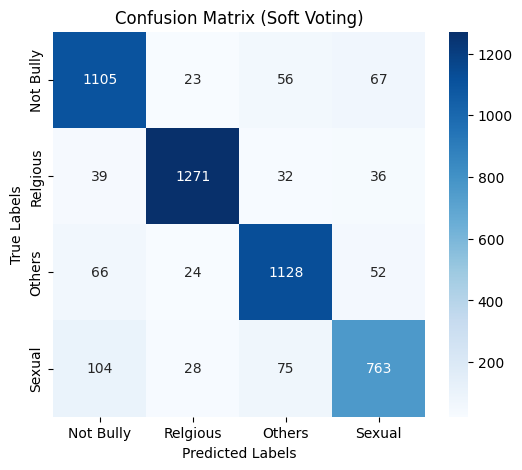

In [22]:
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix for soft voting predictions
conf_matrix = confusion_matrix(y_true, soft_preds)

# Print confusion matrix
print("Confusion Matrix (Soft Voting):")
print(conf_matrix)

# Optionally, you can use seaborn or matplotlib for a visual representation:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Bully', 'Relgious', 'Others', 'Sexual'], yticklabels=['Not Bully', 'Relgious', 'Others', 'Sexual'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Soft Voting)')
plt.show()

In [ ]:
# import pandas as pd
# from transformers import BertTokenizer

# tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")

# # Label mapping
# label_map = {
#     0: "Not Bully",
#     1: "Religious",
#     2: "Others",
#     3: "Sexual"
# }

# comments = []
# for example in mbert_test_dataset:
#     input_ids = example['input_ids']
#     input_ids = input_ids[:example['attention_mask'].sum()]
#     decoded = tokenizer.decode(input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
#     comments.append(decoded)

# # Build full DataFrame
# df = pd.DataFrame({
#     "Comment": comments,
#     "True Label": [label_map[label] for label in y_true],
#     "Predicted Label": [label_map[pred] for pred in soft_preds],
#     "Correct": [yt == yp for yt, yp in zip(y_true, soft_preds)]
# })

# df_wrong = df[df["Correct"] == False]

# df_wrong.to_csv("soft_voting_misclassified_only.csv", index=False)
# print("Saved as soft_voting_misclassified_only.csv ✅")


In [21]:
import pandas as pd
from sklearn.metrics import classification_report

# Convert labels back to numeric for sklearn
true_numeric = y_true
pred_numeric = soft_preds

# Class names (make sure this matches your label_map)
target_names = ["Not Bully", "Religious", "Others", "Sexual"]

# Generate class-wise metrics
report = classification_report(true_numeric, pred_numeric, target_names=target_names, output_dict=True)

# Convert to DataFrame for easy viewing
report_df = pd.DataFrame(report).transpose()

# Round values for neatness
report_df = report_df.round(3)

# Save to CSV (optional)
report_df.to_csv("class_wise_report.csv")

# Display
report_df


,precision,recall,f1-score,support
Not Bully,0.841,0.883,0.862,1251.000
Religious,0.944,0.922,0.933,1378.000
Others,0.874,0.888,0.881,1270.000
Sexual,0.831,0.787,0.808,970.000
accuracy,0.876,0.876,0.876,0.876
macro avg,0.873,0.870,0.871,4869.000
weighted avg,0.877,0.876,0.876,4869.000


In [25]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assume these are loaded from your notebook environment
# mbert_model, banglabert_model, xlmr_model
# mbert_test_dataset, banglabert_test_dataset, xlmr_test_dataset
# test_labels

device = torch.device('cpu')

models = {
    'mBERT': mbert_model,
    'BanglaBERT': banglabert_model,
    'XLM-R': xlmr_model,
}

datasets = {
    'mBERT': mbert_test_dataset,
    'BanglaBERT': banglabert_test_dataset,
    'XLM-R': xlmr_test_dataset,
}

def get_predictions(model, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    model.to(device)
    model.eval()
    all_probs = []
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    return all_probs, all_preds

# Get predictions and probabilities for each model
model_probs = []
model_preds = []

for name in models:
    probs, preds = get_predictions(models[name], datasets[name])
    model_probs.append(probs)
    model_preds.append(preds)

# Ensemble by averaging probabilities
ensemble_probs = np.mean(model_probs, axis=0)
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# True labels as numpy array
true_labels = test_labels.cpu().numpy() if torch.is_tensor(test_labels) else np.array(test_labels)

# Binarize true labels for multiclass ROC-AUC
n_classes = 4
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Calculate ROC-AUC score (macro average)
roc_auc = roc_auc_score(true_labels_bin, ensemble_probs, average='macro', multi_class='ovr')
print(f'Ensemble ROC-AUC Score (macro): {roc_auc:.4f}')

# Plot ROC curve for each class
class_names = ['not bully', 'religious', 'others', 'sexual']

plt.figure(figsize=(8, 6))
fpr = dict()
tpr = dict()
roc_auc_class = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], ensemble_probs[:, i])
    roc_auc_class[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc_class[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title('ROC Curve per Class (Ensemble)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.savefig("ensemble_bangla_roc_curve.png", dpi=300)
plt.show()

# Calculate MCC and Cohen's Kappa on ensemble predictions
mcc = matthews_corrcoef(true_labels, ensemble_preds)
kappa = cohen_kappa_score(true_labels, ensemble_preds)

print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')
print(f"Cohen's Kappa Score: {kappa:.4f}")


C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_10864\2646260844.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


KeyboardInterrupt: 

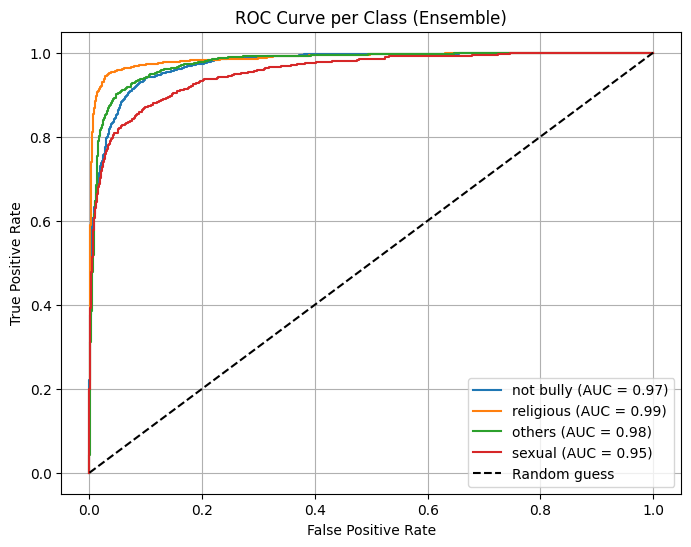

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Example inputs (you should already have these)
# true_labels = numpy array of true class indices
# ensemble_probs = numpy array of predicted probabilities from ensemble model

# Set number of classes and class names
n_classes = 4
class_names = ['not bully', 'religious', 'others', 'sexual']

# Binarize the true labels for multi-class ROC
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr = dict()
tpr = dict()
roc_auc_class = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], ensemble_probs[:, i])
    roc_auc_class[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc_class[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title('ROC Curve per Class (Ensemble)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.savefig("ensemble_bangla_roc_curve.png", dpi=300)
plt.show()


In [27]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, matthews_corrcoef
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize true labels
n_classes = 4
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# ROC-AUC Score (macro average for multiclass)
roc_auc = roc_auc_score(true_labels_bin, ensemble_probs, average='macro', multi_class='ovr')
print(f'Ensemble ROC-AUC Score (macro): {roc_auc:.4f}')

# Cohen’s Kappa Score
kappa = cohen_kappa_score(true_labels, ensemble_preds)
print(f"Cohen's Kappa Score: {kappa:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels, ensemble_preds)
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')


Ensemble ROC-AUC Score (macro): 0.9733
Cohen's Kappa Score: 0.8339
Matthews Correlation Coefficient (MCC): 0.8341


In [1]:
# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
fpr = dict()
tpr = dict()
roc_auc_class = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], ensemble_probs[:, i])
    roc_auc_class[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_class[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title('ROC Curve per Class (Ensemble)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.savefig("ensemble_english_roc_curve.png", dpi=300)
plt.show()

NameError: name 'plt' is not defined